Source
- Scraping Twitter: https://github.com/JustAnotherArchivist/snscrape/tree/master/snscrape
- SNScrape + Tweepy: https://medium.com/@jcldinco/downloading-historical-tweets-using-tweet-ids-via-snscrape-and-tweepy-5f4ecbf19032
- Twitter Scraper (Does not work): https://github.com/taspinar/twitterscraper
- Tweet Preprocessing: https://www.kaggle.com/sreejiths0/efficient-tweet-preprocessing
- Sentiment Analysis: https://medium.com/better-programming/twitter-sentiment-analysis-15d8892c0082


## Bitcoin

In [4]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import os

from newsapi_help_func import *
%load_ext autoreload
%autoreload 2

#Corex Setup
# Install CorEx 
# !pip install corextopic
# !pip install networkx

# Import other packages for examples
import scipy.sparse as ss

from corextopic import corextopic as ct
from corextopic import vis_topic as vt

import pandas as pd
import numpy as np
import json

from collections import Counter
from gensim.parsing.preprocessing import remove_stopwords
import gensim
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors

from wordcloud import WordCloud
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import re, string, unicodedata
import nltk
from nltk import ngrams, word_tokenize, sent_tokenize, FreqDist
from nltk.corpus import stopwords, words
from nltk.stem import LancasterStemmer, WordNetLemmatizer
# nltk.download
# nltk.download('wordnet')
# nltk.download('stopwords')
from nltk.tokenize import TweetTokenizer
# !pip install ekphrasis
# !pip install tweet-preprocessor
import preprocessor as p
from pyemd import emd

import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

import tweepy

import scattertext as st

from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from string import punctuation

import spacy
from spacy import displacy
from spacy.symbols import amod
# Optional - download a language model for SpaCy
# !python -m spacy download en_core_web_sm
# Load the spaCy model
nlp = spacy.load('en_core_web_sm')

#For Sentiment Analysis
from textblob import TextBlob
from wordcloud import WordCloud
plt.style.use('fivethirtyeight')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Key Dates:
- March 10-11, 2020: Before Price Dump
- March 12, 2020: Bitcoin Price Dump
- March 13-14, 2020: After Price Dump

In [2]:
!snscrape twitter-search "#Bitcoin since:2020-03-13 until:2020-03-14" > btc_tweets_afterdump_mar20.txt

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


API Keys from Twitter Developer Account: Exported to environment 

Source: https://developer.twitter.com/en/docs/authentication/guides/authentication-best-practices

In [12]:
consumer_key = os.environ.get('CONSUMER_KEY')
consumer_secret = os.environ.get('CONSUMER_SECRET')
access_token = os.environ.get('ACCESS_TOKEN') 
access_token_secret = os.environ.get('ACCESS_SECRET')
auth = tweepy.OAuthHandler(consumer_key, consumer_secret) 
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth)

 Open .txt or .json using pandas.read_json or pandas.read_csv

In [6]:
tweet_url = pd.read_csv("./data/btc_tweets_afterdump_mar20.txt", index_col= None, header = None, names = ["links"])
tweet_url

links
0      https://twitter.com/xbtmoney/status/1238615823...
1      https://twitter.com/Karalhoin/status/123861579...
2      https://twitter.com/efixteam/status/1238615772...
3      https://twitter.com/Satoshi_Fever/status/12386...
4      https://twitter.com/arstech_biz/status/1238615...
...                                                  ...
19897  https://twitter.com/asens_inc/status/123825344...
19898  https://twitter.com/HourlyBTCUpdate/status/123...
19899  https://twitter.com/status_crypto/status/12382...
19900  https://twitter.com/satparity/status/123825344...
19901  https://twitter.com/CryptoTopCharts/status/123...

[19902 rows x 1 columns]

 Extract tweet_id using .split function

In [7]:
af = lambda x: x["links"].split("/")[-1]
tweet_url['id'] = tweet_url.apply(af, axis=1)
tweet_url.head()

links                   id
0  https://twitter.com/xbtmoney/status/1238615823...  1238615823297593344
1  https://twitter.com/Karalhoin/status/123861579...  1238615793291706368
2  https://twitter.com/efixteam/status/1238615772...  1238615772773208079
3  https://twitter.com/Satoshi_Fever/status/12386...  1238615753869479938
4  https://twitter.com/arstech_biz/status/1238615...  1238615726379814912

Convert tweet_url Series into list

In [8]:
ids = tweet_url['id'].tolist()

Issue looping through all ids, the API is giving an error. Therefore, process the ids by batch or chunks

In [9]:
total_count = len(ids)
chunks = (total_count - 1) // 50 + 1

Create function that would extract all elements that we need from the tweet (username, date and the tweet)

In [10]:
def fetch_tw(ids):
    list_of_tw_status = api.statuses_lookup(ids, tweet_mode= "extended")
    empty_data = pd.DataFrame()
    for status in list_of_tw_status:
            tweet_elem = {"tweet_id": status.id,
                     "screen_name": status.user.screen_name,
                     "tweet":status.full_text,
                     "date":status.created_at}
            empty_data = empty_data.append(tweet_elem, ignore_index = True)
    empty_data.to_csv("./data/btc_tweets_afterdump_mar20.csv", mode="a")

Create another for loop to loop into our batches while processing 50 entries every loop. (That felt like a tongue twister)

In [13]:
for i in range(chunks):
        batch = ids[i*50:(i+1)*50]
        result = fetch_tw(batch)

In [14]:
df_tweets = pd.read_csv('./data/btc_tweets_afterdump_mar20.csv',
                 lineterminator='\n')

In [15]:
df_tweets['date'] = pd.to_datetime(df_tweets['date'], errors='coerce')

In [16]:
df_tweets = df_tweets.sort_values('date')
df_tweets

Unnamed: 0                date      screen_name  \
20299         1.0 2020-03-13 00:00:00  CryptoTopCharts   
20271        24.0 2020-03-13 00:00:01    status_crypto   
20298         0.0 2020-03-13 00:00:01        satparity   
20254         7.0 2020-03-13 00:00:02         bitapeso   
20258        11.0 2020-03-13 00:00:02        asens_inc   
...           ...                 ...              ...   
20093         NaN                 NaT      screen_name   
20144         NaN                 NaT      screen_name   
20195         NaN                 NaT      screen_name   
20246         NaN                 NaT      screen_name   
20297         NaN                 NaT      screen_name   

                                                   tweet  \
20299  Top50 #Cryptocurrency IN/OUT update in last 12...   
20271  #HourlyCryptoStatus (#1 to #3):\n\n#1 #btc (#b...   
20298  1 cent = 206 sats #satparity #bitcoin #stackin...   
20254  Precio actual del #Bitcoin, #Ethereum y #Rippl...   
20258  03/13 09:00現在\n\n#Bitcoin : 529,800円↓\n#NEM #X...   
...                                                  ...   
20093                                              tweet   
20144                                              tweet   
20195                                              tweet   
20246                                              tweet   
20297                                              tweet   

                     tweet_id  
20299  1.2382534410273178e+18  
20271  1.2382534454103245e+18  
20298  1.2382534446386135e+18  
20254   1.238253447427883e+18  
20258   1.238253446861652e+18  
...                       ...  
20093                tweet_id  
20144                tweet_id  
20195                tweet_id  
20246                tweet_id  
20297                tweet_id  

[20300 rows x 5 columns]

In [17]:
df_tweets.dtypes

Unnamed: 0            float64
date           datetime64[ns]
screen_name            object
tweet                  object
tweet_id               object
dtype: object

## Tweet Preprocessing 
Since we are dealing with tweets in this competition, we need to do specific tweet text cleaning along with normal text pre-processing. A tweet may contain:
- URL's
- Mentions
- Hashtags
- Emojis
- Smileys
- Spefic words etc.

To clean the tweet , we can use a python library tweet-preprocessor instead of writing the cleaning logic ourself.

Apply tweet preprocessing first. Defining a preprocess function and using pandas apply to apply it on each value of 'text'. 

Preprocessing:
- Lowercasing
- Punctuation Removal
- Replace extra white spaces
- Stopwords removal
- For stop word removal , i have used gensim library

Source: https://www.kaggle.com/sreejiths0/efficient-tweet-preprocessing

In [18]:
df_tweets['hashtag'] = df_tweets.tweet.apply(lambda x: re.findall(r"#(\w+)", x))
df_tweets['emojis'] = df_tweets.tweet.apply(lambda x: re.findall(r'[^\x00-\x7F]+', x))
df_tweets = df_tweets.dropna()
# df_tweets = df_tweets.drop_duplicates()
df_tweets = df_tweets.drop(['Unnamed: 0', 'tweet_id'], axis=1)

In [19]:
df_tweets

date      screen_name  \
20299 2020-03-13 00:00:00  CryptoTopCharts   
20271 2020-03-13 00:00:01    status_crypto   
20298 2020-03-13 00:00:01        satparity   
20254 2020-03-13 00:00:02         bitapeso   
20258 2020-03-13 00:00:02        asens_inc   
...                   ...              ...   
14    2020-03-13 23:59:36      arstech_biz   
0     2020-03-13 23:59:42    Satoshi_Fever   
7     2020-03-13 23:59:47         efixteam   
2     2020-03-13 23:59:52        Karalhoin   
23    2020-03-13 23:59:59         xbtmoney   

                                                   tweet  \
20299  Top50 #Cryptocurrency IN/OUT update in last 12...   
20271  #HourlyCryptoStatus (#1 to #3):\n\n#1 #btc (#b...   
20298  1 cent = 206 sats #satparity #bitcoin #stackin...   
20254  Precio actual del #Bitcoin, #Ethereum y #Rippl...   
20258  03/13 09:00現在\n\n#Bitcoin : 529,800円↓\n#NEM #X...   
...                                                  ...   
14     My answer to How much do you believe the idea ...   
0                       #Bitcoin https://t.co/AWiv3j4JGp   
7      https://t.co/zgVSDq0mx0 \nnew video...\n#Europ...   
2      This is all I have to say given known current ...   
23     New version of crypto wallet QPocket adds cold...   

                                                 hashtag  \
20299         [Cryptocurrency, crypto, bitcoin, altcoin]   
20271  [HourlyCryptoStatus, 1, 3, 1, btc, bitcoin, 2,...   
20298      [satparity, bitcoin, stackingsats, stacksats]   
20254                        [Bitcoin, Ethereum, Ripple]   
20258      [Bitcoin, NEM, XEM, Monacoin, Ethereum, Zaif]   
...                                                  ...   
14     [cryptocurrency, crypto, blockchain, Bitcoin, ...   
0                                              [Bitcoin]   
7      [Europe, Italy, SubscribeNow, Romania, Bitcoin...   
2                                              [bitcoin]   
23                                   [XBT, BTC, Bitcoin]   

                         emojis  
20299                        []  
20271                        []  
20298                        []  
20254                       [í]  
20258  [現在, 円↓, 円↓, 円↓, 円→, 円↓]  
...                         ...  
14                           []  
0                            []  
7                            []  
2                           [🚀]  
23                           []  

[19902 rows x 5 columns]

Consider Lemmatizing to shorten words to root; if necessary:

lemmatizer = WordNetLemmatizer()
 
lemmatizer.lemmatize("rocks")

In [20]:
def preprocess_tweet(row):
    text = row['tweet']
    text = p.clean(text) #clean to normal text removes hashtags and emojis
    text = re.sub(r'[^\w]', ' ', text) #Removes all symbols
    text = text.lower() # lowercases all words
    text = re.sub(r'\d+', '', text) # Removes numbers
    text = re.sub('RT[\s]+', '', text) # Removing RT (Retweet?)
    text = re.sub('https?:\/\/\S+', '', text) # Removing hyperlink

    # my_stop_words = STOPWORDS.union(set(['Bitcoin', 'BTC']))
    text = remove_stopwords(text) #removes stopwords
    text = re.sub(r'\W*\b\w{1,2}\b', '', text) #Removes words between 1 and 2 characters short
    
    return text

df_tweets['tweet'] = df_tweets.apply(preprocess_tweet, axis=1)

df_tweets['tokens'] = df_tweets['tweet'].apply(word_tokenize) 

df_tweets.head()

date      screen_name  \
20299 2020-03-13 00:00:00  CryptoTopCharts   
20271 2020-03-13 00:00:01    status_crypto   
20298 2020-03-13 00:00:01        satparity   
20254 2020-03-13 00:00:02         bitapeso   
20258 2020-03-13 00:00:02        asens_inc   

                                                   tweet  \
20299                            update hours kcsout rvn   
20271                                        usd usd usd   
20298                                          cent sats   
20254  precio actual del usd mxn btc mxn eth mxn xrp ...   
20258                                                      

                                                 hashtag  \
20299         [Cryptocurrency, crypto, bitcoin, altcoin]   
20271  [HourlyCryptoStatus, 1, 3, 1, btc, bitcoin, 2,...   
20298      [satparity, bitcoin, stackingsats, stacksats]   
20254                        [Bitcoin, Ethereum, Ripple]   
20258      [Bitcoin, NEM, XEM, Monacoin, Ethereum, Zaif]   

                         emojis  \
20299                        []   
20271                        []   
20298                        []   
20254                       [í]   
20258  [現在, 円↓, 円↓, 円↓, 円→, 円↓]   

                                                  tokens  
20299                       [update, hours, kcsout, rvn]  
20271                                    [usd, usd, usd]  
20298                                       [cent, sats]  
20254  [precio, actual, del, usd, mxn, btc, mxn, eth,...  
20258                                                 []

In [21]:
df_tweets

date      screen_name  \
20299 2020-03-13 00:00:00  CryptoTopCharts   
20271 2020-03-13 00:00:01    status_crypto   
20298 2020-03-13 00:00:01        satparity   
20254 2020-03-13 00:00:02         bitapeso   
20258 2020-03-13 00:00:02        asens_inc   
...                   ...              ...   
14    2020-03-13 23:59:36      arstech_biz   
0     2020-03-13 23:59:42    Satoshi_Fever   
7     2020-03-13 23:59:47         efixteam   
2     2020-03-13 23:59:52        Karalhoin   
23    2020-03-13 23:59:59         xbtmoney   

                                                   tweet  \
20299                            update hours kcsout rvn   
20271                                        usd usd usd   
20298                                          cent sats   
20254  precio actual del usd mxn btc mxn eth mxn xrp ...   
20258                                                      
...                                                  ...   
14     answer believe idea engaging online business l...   
0                                                          
7                                              new video   
2      given known current data heading couch relax b...   
23     new version crypto wallet qpocket adds cold st...   

                                                 hashtag  \
20299         [Cryptocurrency, crypto, bitcoin, altcoin]   
20271  [HourlyCryptoStatus, 1, 3, 1, btc, bitcoin, 2,...   
20298      [satparity, bitcoin, stackingsats, stacksats]   
20254                        [Bitcoin, Ethereum, Ripple]   
20258      [Bitcoin, NEM, XEM, Monacoin, Ethereum, Zaif]   
...                                                  ...   
14     [cryptocurrency, crypto, blockchain, Bitcoin, ...   
0                                              [Bitcoin]   
7      [Europe, Italy, SubscribeNow, Romania, Bitcoin...   
2                                              [bitcoin]   
23                                   [XBT, BTC, Bitcoin]   

                         emojis  \
20299                        []   
20271                        []   
20298                        []   
20254                       [í]   
20258  [現在, 円↓, 円↓, 円↓, 円→, 円↓]   
...                         ...   
14                           []   
0                            []   
7                            []   
2                           [🚀]   
23                           []   

                                                  tokens  
20299                       [update, hours, kcsout, rvn]  
20271                                    [usd, usd, usd]  
20298                                       [cent, sats]  
20254  [precio, actual, del, usd, mxn, btc, mxn, eth,...  
20258                                                 []  
...                                                  ...  
14     [answer, believe, idea, engaging, online, busi...  
0                                                     []  
7                                           [new, video]  
2      [given, known, current, data, heading, couch, ...  
23     [new, version, crypto, wallet, qpocket, adds, ...  

[19902 rows x 6 columns]

Everything seems cleaned up so now we can move onto Sentiment Analysis.

## Sentiment Analysis

The functions called will add the tweets’ subjectivity and polarity into two columns in the DataFrame. 
- getSubjectivity function: How subjective/opinionated the text is 
    - Score of 0 is fact
    - Score of +1 is very much an opinion 
- getPolarity: How positive or negative the text is
    - Score of -1 is the highest negative score
    - Score of +1 is the highest positive score

Source: https://medium.com/better-programming/twitter-sentiment-analysis-15d8892c0082

In [22]:
# Create a function to get the subjectivity
def getSubjectivity(text):
   return TextBlob(text).sentiment.subjectivity

# Create a function to get the polarity
def getPolarity(text):
   return  TextBlob(text).sentiment.polarity


# Create two new columns 'Subjectivity' & 'Polarity'
df_tweets['Subjectivity'] = df_tweets['tweet'].apply(getSubjectivity)
df_tweets['Polarity'] = df_tweets['tweet'].apply(getPolarity)

# Show the new dataframe with columns 'Subjectivity' & 'Polarity'
df_tweets

date      screen_name  \
20299 2020-03-13 00:00:00  CryptoTopCharts   
20271 2020-03-13 00:00:01    status_crypto   
20298 2020-03-13 00:00:01        satparity   
20254 2020-03-13 00:00:02         bitapeso   
20258 2020-03-13 00:00:02        asens_inc   
...                   ...              ...   
14    2020-03-13 23:59:36      arstech_biz   
0     2020-03-13 23:59:42    Satoshi_Fever   
7     2020-03-13 23:59:47         efixteam   
2     2020-03-13 23:59:52        Karalhoin   
23    2020-03-13 23:59:59         xbtmoney   

                                                   tweet  \
20299                            update hours kcsout rvn   
20271                                        usd usd usd   
20298                                          cent sats   
20254  precio actual del usd mxn btc mxn eth mxn xrp ...   
20258                                                      
...                                                  ...   
14     answer believe idea engaging online business l...   
0                                                          
7                                              new video   
2      given known current data heading couch relax b...   
23     new version crypto wallet qpocket adds cold st...   

                                                 hashtag  \
20299         [Cryptocurrency, crypto, bitcoin, altcoin]   
20271  [HourlyCryptoStatus, 1, 3, 1, btc, bitcoin, 2,...   
20298      [satparity, bitcoin, stackingsats, stacksats]   
20254                        [Bitcoin, Ethereum, Ripple]   
20258      [Bitcoin, NEM, XEM, Monacoin, Ethereum, Zaif]   
...                                                  ...   
14     [cryptocurrency, crypto, blockchain, Bitcoin, ...   
0                                              [Bitcoin]   
7      [Europe, Italy, SubscribeNow, Romania, Bitcoin...   
2                                              [bitcoin]   
23                                   [XBT, BTC, Bitcoin]   

                         emojis  \
20299                        []   
20271                        []   
20298                        []   
20254                       [í]   
20258  [現在, 円↓, 円↓, 円↓, 円→, 円↓]   
...                         ...   
14                           []   
0                            []   
7                            []   
2                           [🚀]   
23                           []   

                                                  tokens  Subjectivity  \
20299                       [update, hours, kcsout, rvn]      0.000000   
20271                                    [usd, usd, usd]      0.000000   
20298                                       [cent, sats]      0.000000   
20254  [precio, actual, del, usd, mxn, btc, mxn, eth,...      0.100000   
20258                                                 []      0.000000   
...                                                  ...           ...   
14     [answer, believe, idea, engaging, online, busi...      0.700000   
0                                                     []      0.000000   
7                                           [new, video]      0.454545   
2      [given, known, current, data, heading, couch, ...      0.825000   
23     [new, version, crypto, wallet, qpocket, adds, ...      0.727273   

       Polarity  
20299  0.000000  
20271  0.000000  
20298  0.000000  
20254  0.000000  
20258  0.000000  
...         ...  
14     0.400000  
0      0.000000  
7      0.136364  
2     -0.150000  
23    -0.231818  

[19902 rows x 8 columns]

In [23]:
# Create a function to compute negative (-1), neutral (0) and positive (+1) analysis
def getAnalysis(score):
    if score < 0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Positive'

df_tweets['Analysis'] = df_tweets['Polarity'].apply(getAnalysis)
# Show the dataframe
df_tweets

date      screen_name  \
20299 2020-03-13 00:00:00  CryptoTopCharts   
20271 2020-03-13 00:00:01    status_crypto   
20298 2020-03-13 00:00:01        satparity   
20254 2020-03-13 00:00:02         bitapeso   
20258 2020-03-13 00:00:02        asens_inc   
...                   ...              ...   
14    2020-03-13 23:59:36      arstech_biz   
0     2020-03-13 23:59:42    Satoshi_Fever   
7     2020-03-13 23:59:47         efixteam   
2     2020-03-13 23:59:52        Karalhoin   
23    2020-03-13 23:59:59         xbtmoney   

                                                   tweet  \
20299                            update hours kcsout rvn   
20271                                        usd usd usd   
20298                                          cent sats   
20254  precio actual del usd mxn btc mxn eth mxn xrp ...   
20258                                                      
...                                                  ...   
14     answer believe idea engaging online business l...   
0                                                          
7                                              new video   
2      given known current data heading couch relax b...   
23     new version crypto wallet qpocket adds cold st...   

                                                 hashtag  \
20299         [Cryptocurrency, crypto, bitcoin, altcoin]   
20271  [HourlyCryptoStatus, 1, 3, 1, btc, bitcoin, 2,...   
20298      [satparity, bitcoin, stackingsats, stacksats]   
20254                        [Bitcoin, Ethereum, Ripple]   
20258      [Bitcoin, NEM, XEM, Monacoin, Ethereum, Zaif]   
...                                                  ...   
14     [cryptocurrency, crypto, blockchain, Bitcoin, ...   
0                                              [Bitcoin]   
7      [Europe, Italy, SubscribeNow, Romania, Bitcoin...   
2                                              [bitcoin]   
23                                   [XBT, BTC, Bitcoin]   

                         emojis  \
20299                        []   
20271                        []   
20298                        []   
20254                       [í]   
20258  [現在, 円↓, 円↓, 円↓, 円→, 円↓]   
...                         ...   
14                           []   
0                            []   
7                            []   
2                           [🚀]   
23                           []   

                                                  tokens  Subjectivity  \
20299                       [update, hours, kcsout, rvn]      0.000000   
20271                                    [usd, usd, usd]      0.000000   
20298                                       [cent, sats]      0.000000   
20254  [precio, actual, del, usd, mxn, btc, mxn, eth,...      0.100000   
20258                                                 []      0.000000   
...                                                  ...           ...   
14     [answer, believe, idea, engaging, online, busi...      0.700000   
0                                                     []      0.000000   
7                                           [new, video]      0.454545   
2      [given, known, current, data, heading, couch, ...      0.825000   
23     [new, version, crypto, wallet, qpocket, adds, ...      0.727273   

       Polarity  Analysis  
20299  0.000000   Neutral  
20271  0.000000   Neutral  
20298  0.000000   Neutral  
20254  0.000000   Neutral  
20258  0.000000   Neutral  
...         ...       ...  
14     0.400000  Positive  
0      0.000000   Neutral  
7      0.136364  Positive  
2     -0.150000  Negative  
23    -0.231818  Negative  

[19902 rows x 9 columns]

In [24]:
df_tweets.to_csv("./data/btc_tweets_afterdump_mar20_cleaned.csv")

In [25]:
df_tweets = pd.read_csv('./data/btc_tweets_afterdump_mar20_cleaned.csv')
df_tweets = df_tweets.drop(['Unnamed: 0'], axis=1)
df_tweets = df_tweets.dropna()
df_tweets.sort_values('date')

date      screen_name  \
0      2020-03-13 00:00:00  CryptoTopCharts   
1      2020-03-13 00:00:01    status_crypto   
2      2020-03-13 00:00:01        satparity   
3      2020-03-13 00:00:02         bitapeso   
5      2020-03-13 00:00:02  bitcoin_bunnies   
...                    ...              ...   
19896  2020-03-13 23:59:28  VisionaryFinanc   
19897  2020-03-13 23:59:36      arstech_biz   
19899  2020-03-13 23:59:47         efixteam   
19900  2020-03-13 23:59:52        Karalhoin   
19901  2020-03-13 23:59:59         xbtmoney   

                                                   tweet  \
0                                update hours kcsout rvn   
1                                            usd usd usd   
2                                              cent sats   
3      precio actual del usd mxn btc mxn eth mxn xrp ...   
5                                                buy dip   
...                                                  ...   
19896  declares national emergency amp rally price fe...   
19897  answer believe idea engaging online business l...   
19899                                          new video   
19900  given known current data heading couch relax b...   
19901  new version crypto wallet qpocket adds cold st...   

                                                 hashtag emojis  \
0      ['Cryptocurrency', 'crypto', 'bitcoin', 'altco...     []   
1      ['HourlyCryptoStatus', '1', '3', '1', 'btc', '...     []   
2      ['satparity', 'bitcoin', 'stackingsats', 'stac...     []   
3                      ['Bitcoin', 'Ethereum', 'Ripple']  ['í']   
5                                 ['bitcoin', 'bunnies']     []   
...                                                  ...    ...   
19896  ['Trump', 'Stocks', 'Bitcoin', 'Cryptocurrenci...     []   
19897  ['cryptocurrency', 'crypto', 'blockchain', 'Bi...     []   
19899  ['Europe', 'Italy', 'SubscribeNow', 'Romania',...     []   
19900                                        ['bitcoin']  ['🚀']   
19901                          ['XBT', 'BTC', 'Bitcoin']     []   

                                                  tokens  Subjectivity  \
0                   ['update', 'hours', 'kcsout', 'rvn']      0.000000   
1                                  ['usd', 'usd', 'usd']      0.000000   
2                                       ['cent', 'sats']      0.000000   
3      ['precio', 'actual', 'del', 'usd', 'mxn', 'btc...      0.100000   
5                                         ['buy', 'dip']      0.000000   
...                                                  ...           ...   
19896  ['declares', 'national', 'emergency', 'amp', '...      1.000000   
19897  ['answer', 'believe', 'idea', 'engaging', 'onl...      0.700000   
19899                                   ['new', 'video']      0.454545   
19900  ['given', 'known', 'current', 'data', 'heading...      0.825000   
19901  ['new', 'version', 'crypto', 'wallet', 'qpocke...      0.727273   

       Polarity  Analysis  
0      0.000000   Neutral  
1      0.000000   Neutral  
2      0.000000   Neutral  
3      0.000000   Neutral  
5      0.000000   Neutral  
...         ...       ...  
19896 -0.125000  Negative  
19897  0.400000  Positive  
19899  0.136364  Positive  
19900 -0.150000  Negative  
19901 -0.231818  Negative  

[17305 rows x 9 columns]

# Word Clouds

Let's observe how well the sentiments are distributed by plotting the common words in a word clouds.
- Word cloud (also known as text clouds or tag clouds) is a visualization, the more a specific word appears in the text, the bigger and bolder it appears in the word cloud.

It looks like the words "participate" and "amazing" appear a lot for Bitcoins past 14,000+ tweets.

In [26]:
plt.style.use('seaborn-whitegrid')
mpl.rcParams['figure.figsize'] = [20.0, 10.0]

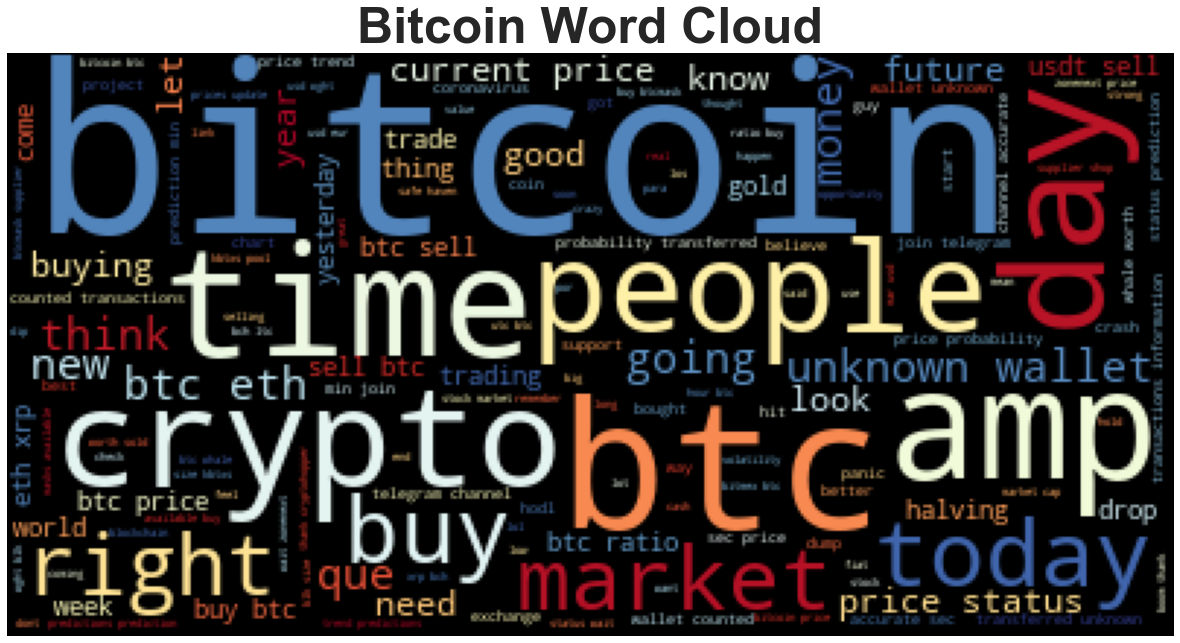

In [27]:
# Generate the Bitcoin word cloud
allWords = ' '.join([twts for twts in df_tweets['tweet']])
wordcloud = WordCloud(colormap="RdYlBu").generate(allWords)
plt.imshow(wordcloud)
plt.axis("off")
fontdict = {"fontsize": 50, "fontweight": "bold"}
plt.title("Bitcoin Word Cloud", fontdict=fontdict)
plt.show()

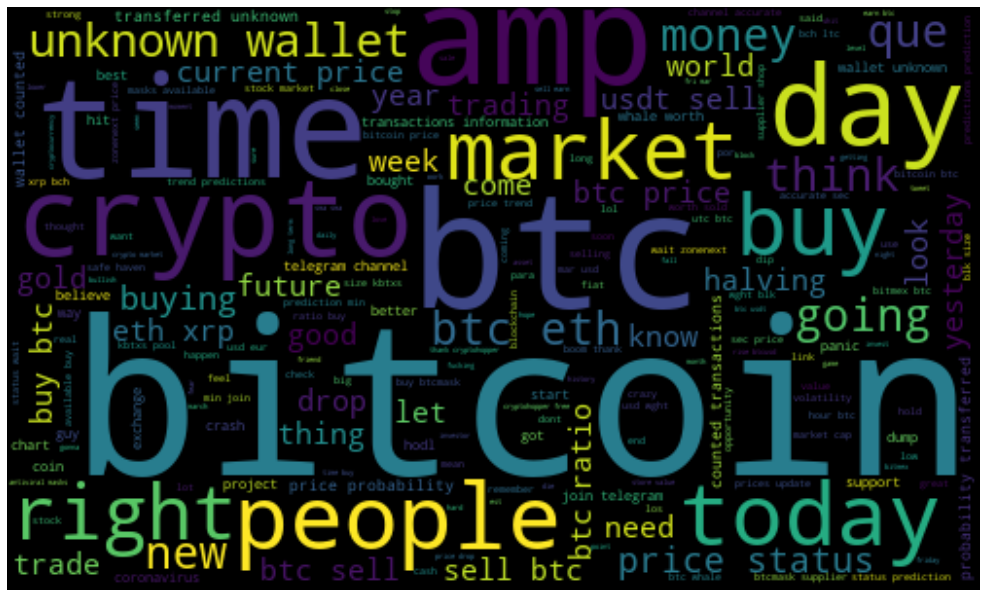

In [28]:
# word cloud visualization and potentially combine hashtags? 
wordCloud = WordCloud(width=500, height=300, random_state=21, max_font_size=110).generate(allWords)

plt.imshow(wordCloud, interpolation="bilinear")
plt.axis('off')
plt.show()

Function below computes the negative (-1), neutral (0), and positive (+1) analysis, and adds it to a new column called Analysis

Prints the positive tweets in ascending order. The most positive tweet is the #1 tweet.

In [29]:
# Printing positive tweets 
print('Printing positive tweets:\n')
j=1
sortedDF = df_tweets.sort_values(by=['Polarity']) #Sort the tweets
for i in range(0, sortedDF.shape[0] ):
    if( sortedDF['Analysis'][i] == 'Positive'):
        print(str(j) + ') '+ sortedDF['tweet'][i])
        print()
        j= j+1

Printing positive tweets:



KeyError: 4

Prints the negative tweets in ascending order. The most negative tweet is the #1 tweet.

In [30]:
# Printing negative tweets  
print('Printing negative tweets:\n')
j=1
sortedDF = df_tweets.sort_values(by=['Polarity'],ascending=False) #Sort the tweets
for i in range(0, sortedDF.shape[0] ):
    if( sortedDF['Analysis'][i] == 'Negative'):
        print(str(j) + ') '+sortedDF['tweet'][i])
        print()
        j=j+1

Printing negative tweets:



KeyError: 4

### Fix statement below
Plot the polarity and subjectivity as a scatter plot. It looks like the majority of the tweets are positive, as many of the points are on the right side of the polarity at value 0.00.

Print the percentage of positive tweets. About 43.6% of the tweets are considered positive tweets.

In [31]:
# Print the percentage of positive tweets
ptweets = df_tweets[df_tweets.Analysis == 'Positive']
ptweets = ptweets['tweet']
ptweets

round( (ptweets.shape[0] / df_tweets.shape[0]) * 100 , 1)

30.2

Print the percentage of negative tweets. About 5.2% of the tweets are considered negative tweets.

In [32]:
# Print the percentage of negative tweets
ntweets = df_tweets[df_tweets.Analysis == 'Negative']
ntweets = ntweets['tweet']
ntweets

round( (ntweets.shape[0] / df_tweets.shape[0]) * 100, 1)

13.9

In [33]:
# Show the value counts
df_tweets['Analysis'].value_counts()

Neutral     9679
Positive    5226
Negative    2400
Name: Analysis, dtype: int64

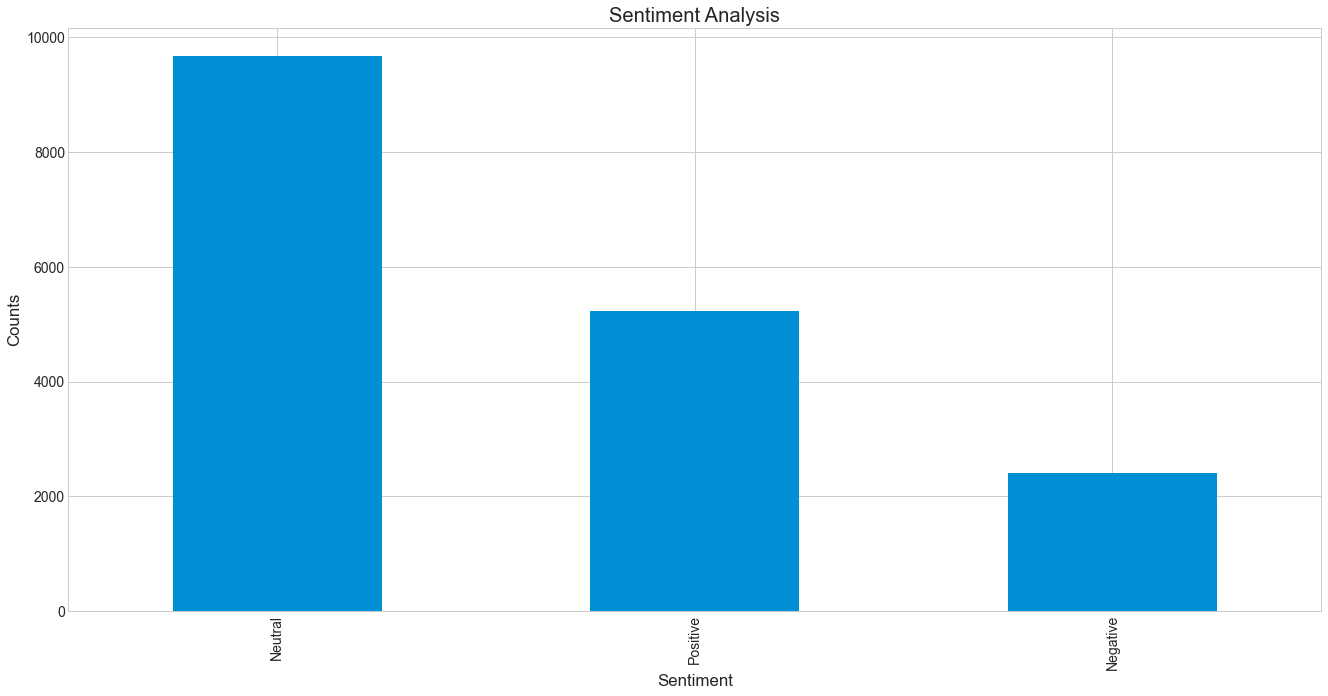

In [34]:
# Plotting and visualizing the counts
plt.title('Sentiment Analysis')
plt.xlabel('Sentiment')
plt.ylabel('Counts')
df_tweets['Analysis'].value_counts().plot(kind = 'bar')
plt.show()

# Named Entity Recognition

In this section, you will build a named entity recognition model for both coins and visualize the tags using SpaCy.

## Bitcoin NER

In [88]:
# Concatenate all of the bitcoin text together
flat_btc_text_str = " ".join(df_tweets.tweet.to_list())
print(flat_btc_text_str)

despite longer having worth portfolio current alts skin game bought lol coming soon btcjpy current price status going upnext price status prediction min join telegram channel accurate sec price trend predictions prediction current price status going upnext price status prediction min join telegram channel accurate sec price trend predictions prediction damn obvious banks governments partnered ripple ripplenet home ripple introduces revolutionary product connecting clients libra association member offers explanation crypto market decline xbt usdi remember exact techniques measured moves correctly short term potentially form bounce long  amp today long world losing shit hahahahahah shit stocks shit dollars ownership beats debt nation currencies disaster bitcoin daily seeks regulate crypto ubi sounds phenomenal tim xemusd falling wedge forex trader ultimate guide beginners talking stock market crash oil prices plummeting dumping talking real topics like anniversary death price changes hou

In [89]:
# Run the NER processor on all of the text
btc_doc = nlp(flat_btc_text_str)
btc_doc.user_data["title"] = "Bitcoin NER"
# Add a title to the document

In [90]:
# Render the visualization
displacy.render(btc_doc,style='ent')

spaCy tokenizes text in an entirely nondestructive manner... The underlying text does not change... spaCy does not explicitly break the original text into a list, but tokens can be accessed by index span.

spaCy provides syntactic parsing to show word usage, thus creating a dependency tree

In [92]:
for token in btc_doc:
    if token.dep_ == 'amod':
        print(f"ADJ MODIFIER: {token.text} --> NOUN: {token.head}")

interested --> NOUN: attempts
ADJ MODIFIER: devoted --> NOUN: rewards
ADJ MODIFIER: great --> NOUN: rewards
ADJ MODIFIER: arrive --> NOUN: darkness
ADJ MODIFIER: long --> NOUN: opportunity
ADJ MODIFIER: mda --> NOUN: opportunity
ADJ MODIFIER: latest --> NOUN: sources
ADJ MODIFIER: global --> NOUN: sources
ADJ MODIFIER: real --> NOUN: time
ADJ MODIFIER: grateful --> NOUN: devotion
ADJ MODIFIER: early --> NOUN: days
ADJ MODIFIER: light --> NOUN: blocks
ADJ MODIFIER: insignificant --> NOUN: blocks
ADJ MODIFIER: bitcoin --> NOUN: data
ADJ MODIFIER: daily --> NOUN: profit
ADJ MODIFIER: updated --> NOUN: hour
ADJ MODIFIER: looking --> NOUN: schiff
ADJ MODIFIER: schiff --> NOUN: calls
ADJ MODIFIER: horrible --> NOUN: calls
ADJ MODIFIER: historical --> NOUN: calls
ADJ MODIFIER: prior --> NOUN: calls
ADJ MODIFIER: historical --> NOUN: calls
ADJ MODIFIER: biggest --> NOUN: gold
ADJ MODIFIER: glorious --> NOUN: chest
ADJ MODIFIER: divisible --> NOUN: draw
ADJ MODIFIER: vertical --> NOUN: infiniti

### Named Entity Recognition
To see which tokens spaCy identifies as named entities... simply cycle through `btc_doc.ents`"

In [93]:
for ent in btc_doc.ents:
    print(ent.text, ent.label_)


josema estamos PERSON
viviendo algo PERSON
completo china stock markets ORG
bpi ORG
join btc cos phb stx PERSON
nas blz xem snt wan PERSON
vib evx PERSON
bmarket cap bitcoin PERSON
pool day DATE
million CARDINAL
digital trust ORG
pool week EVENT
pool week EVENT
today DATE
pool month DATE
pool month DATE
fiat launch exchange ORG
month DATE
dnn arkasndaki nedenler PERSON
bitcoinin son PERSON
arkasnda hangi PERSON
del usd mxn ORG
btc mxn eth mxn xrp mxn ltc PERSON
hours TIME
hourly TIME
nuovo post ORG
new zealand GPE
day DATE
tak sedikit PERSON
analis NORP
berulang kali menggambarkan PERSON
kemampuannya untuk PERSON
pasar telah PERSON
yaklaan btc usd amp PERSON
araclyla PERSON
farif PERSON
months DATE
revamps proposal PERSON
tom lee PERSON
hedgethomas lee PERSON
tomorrow DATE
morning TIME
sec ORG
vix ORG
march DATE
atom xtz PERSON
knc algo kava PERSON
latest week DATE
seconds TIME
tuesday DATE
midday TIME
today DATE
usd hour TIME
eur ltc PERSON
xlm slt atom PERSON
ada kcs PERSON
xrp PERS

In [35]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(df_tweets['tweet'], df_tweets['Analysis'], test_size=0.3, random_state=42)

In [44]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
# The first document-term matrix has default Count Vectorizer values - counts of unigrams
# min_df sets parameter for columns with minimum amount of values
cv1 = CountVectorizer(stop_words='english', min_df=4)

X_train_cv1 = cv1.fit_transform(X_train)
X_test_cv1  = cv1.transform(X_test)

X_train_cv1_df = pd.DataFrame(X_train_cv1.toarray(), columns=cv1.get_feature_names()).head()
X_train_cv1_df

aan  abajo  abd  aber  ability  able  absolute  absolutely  accept  \
0    0      0    0     0        0     0         0           0       0   
1    0      0    0     0        0     0         0           0       0   
2    0      0    0     0        0     0         0           0       0   
3    0      0    0     0        0     0         0           0       0   
4    0      0    0     0        0     0         0           0       0   

   accepted  ...  zero  zijn  zil  zombie  zona  zone  zonenext  zones  zoom  \
0         0  ...     0     0    0       0     0     0         0      0     0   
1         0  ...     0     0    0       0     0     0         0      0     0   
2         0  ...     0     0    0       0     0     0         0      0     0   
3         0  ...     0     0    0       0     0     0         0      0     0   
4         0  ...     0     0    0       0     0     0         0      0     0   

   zrx  
0    0  
1    0  
2    0  
3    0  
4    0  

[5 rows x 3699 columns]

In [45]:
# The second document-term matrix has both unigrams and bigrams, and indicators instead of counts
cv2 = CountVectorizer(ngram_range=(1,2), binary=True, stop_words='english', min_df=4)

X_train_cv2 = cv2.fit_transform(X_train)
X_test_cv2  = cv2.transform(X_test)

X_train_cv2_df = pd.DataFrame(X_train_cv2.toarray(), columns=cv2.get_feature_names()).head()
X_train_cv2_df

aan  abajo  abd  aber  ability  able  absolute  absolutely  accept  \
0    0      0    0     0        0     0         0           0       0   
1    0      0    0     0        0     0         0           0       0   
2    0      0    0     0        0     0         0           0       0   
3    0      0    0     0        0     0         0           0       0   
4    0      0    0     0        0     0         0           0       0   

   accept bitcoin  ...  zil  zil poe  zombie  zona  zone  zonenext  \
0               0  ...    0        0       0     0     0         0   
1               0  ...    0        0       0     0     0         0   
2               0  ...    0        0       0     0     0         0   
3               0  ...    0        0       0     0     0         0   
4               0  ...    0        0       0     0     0         0   

   zonenext price  zones  zoom  zrx  
0               0      0     0    0  
1               0      0     0    0  
2               0      0     0    0  
3               0      0     0    0  
4               0      0     0    0  

[5 rows x 5597 columns]

### TF-IDF

In [46]:
# Create TF-IDF versions of the Count Vectorizers created earlier in the exercise
# min_df parameter sets minimum amount/column
tfidf1 = TfidfVectorizer(stop_words='english',min_df=0.0003)
X_train_tfidf1 = tfidf1.fit_transform(X_train)
X_test_tfidf1  = tfidf1.transform(X_test)

pd.DataFrame(X_train_tfidf1.toarray(), columns=tfidf1.get_feature_names()).head()

aan  abajo  abd  aber  ability  able  absolute  absolutely  accept  \
0  0.0    0.0  0.0   0.0      0.0   0.0       0.0         0.0     0.0   
1  0.0    0.0  0.0   0.0      0.0   0.0       0.0         0.0     0.0   
2  0.0    0.0  0.0   0.0      0.0   0.0       0.0         0.0     0.0   
3  0.0    0.0  0.0   0.0      0.0   0.0       0.0         0.0     0.0   
4  0.0    0.0  0.0   0.0      0.0   0.0       0.0         0.0     0.0   

   accepted  ...  zero  zijn  zil  zombie  zona  zone  zonenext  zones  zoom  \
0       0.0  ...   0.0   0.0  0.0     0.0   0.0   0.0       0.0    0.0   0.0   
1       0.0  ...   0.0   0.0  0.0     0.0   0.0   0.0       0.0    0.0   0.0   
2       0.0  ...   0.0   0.0  0.0     0.0   0.0   0.0       0.0    0.0   0.0   
3       0.0  ...   0.0   0.0  0.0     0.0   0.0   0.0       0.0    0.0   0.0   
4       0.0  ...   0.0   0.0  0.0     0.0   0.0   0.0       0.0    0.0   0.0   

   zrx  
0  0.0  
1  0.0  
2  0.0  
3  0.0  
4  0.0  

[5 rows x 3699 columns]

In [47]:
tfidf2 = TfidfVectorizer(ngram_range=(1,2), binary=True, stop_words='english', min_df=0.0003)
X_train_tfidf2 = tfidf2.fit_transform(X_train)
X_test_tfidf2  = tfidf2.transform(X_test)

pd.DataFrame(X_train_tfidf2.toarray(), columns=tfidf2.get_feature_names()).head()

aan  abajo  abd  aber  ability  able  absolute  absolutely  accept  \
0  0.0    0.0  0.0   0.0      0.0   0.0       0.0         0.0     0.0   
1  0.0    0.0  0.0   0.0      0.0   0.0       0.0         0.0     0.0   
2  0.0    0.0  0.0   0.0      0.0   0.0       0.0         0.0     0.0   
3  0.0    0.0  0.0   0.0      0.0   0.0       0.0         0.0     0.0   
4  0.0    0.0  0.0   0.0      0.0   0.0       0.0         0.0     0.0   

   accept bitcoin  ...  zil  zil poe  zombie  zona  zone  zonenext  \
0             0.0  ...  0.0      0.0     0.0   0.0   0.0       0.0   
1             0.0  ...  0.0      0.0     0.0   0.0   0.0       0.0   
2             0.0  ...  0.0      0.0     0.0   0.0   0.0       0.0   
3             0.0  ...  0.0      0.0     0.0   0.0   0.0       0.0   
4             0.0  ...  0.0      0.0     0.0   0.0   0.0       0.0   

   zonenext price  zones  zoom  zrx  
0             0.0    0.0   0.0  0.0  
1             0.0    0.0   0.0  0.0  
2             0.0    0.0   0.0  0.0  
3             0.0    0.0   0.0  0.0  
4             0.0    0.0   0.0  0.0  

[5 rows x 5597 columns]

## Topic Modeling with Matrix Factorization
### Latent Semantic Analysis (LSA)

Sklearn's TruncatedSVD is designed to perform singular value decomposition on a count vectorizer or TF-IDF vectorizer object. Read up on the [documentation](https://scikit-learn.org/stable/modules/decomposition.html), which also discusses NMF and LDA.

> TruncatedSVD is very similar to PCA, but differs in that the matrix *X* does not need to be centered. When the columnwise (per-feature) means of *X* are subtracted from the feature values, truncated SVD on the resulting matrix is equivalent to PCA. In practical terms, this means that the TruncatedSVD transformer accepts scipy.sparse matrices without the need to densify them, as densifying may fill up memory even for medium-sized document collections.

> While the TruncatedSVD transformer works with any feature matrix, using it on tf–idf matrices is recommended over raw frequency counts in an LSA/document processing setting. In particular, sublinear scaling and inverse document frequency should be turned on (sublinear_tf=True, use_idf=True) to bring the feature values closer to a Gaussian distribution, compensating for LSA’s erroneous assumptions about textual data.

In [48]:
# Latent Semantic Analysis (LSA) is just another name for Singular Value Decomposition (SVD) applied to Natural Language Processing (NLP)
lsa = TruncatedSVD(3)
btc_doc_topic = lsa.fit_transform(X_train_cv1)
lsa.explained_variance_ratio_

array([0.03625913, 0.03270247, 0.0200507 ])

The U matrix shows us the 2 resulting topics, and the terms that are associated with each topic. In this case:

In [49]:
topic_word = pd.DataFrame(lsa.components_.round(3),
             index = ["component_1","component_2",'component_3'],
             columns = cv1.get_feature_names())
topic_word

aan  abajo    abd   aber  ability   able  absolute  absolutely  \
component_1  0.001  0.000  0.000  0.000    0.000  0.002     0.001       0.001   
component_2 -0.000 -0.000 -0.000  0.000    0.000  0.000     0.000       0.001   
component_3 -0.000  0.001  0.001  0.001    0.001  0.003     0.000       0.002   

             accept  accepted  ...   zero  zijn    zil  zombie   zona   zone  \
component_1   0.001     0.000  ...  0.006   0.0  0.002     0.0  0.001  0.004   
component_2   0.001    -0.000  ...  0.002  -0.0  0.000     0.0 -0.000  0.000   
component_3   0.005     0.001  ...  0.003  -0.0  0.004     0.0  0.000 -0.001   

             zonenext  zones   zoom    zrx  
component_1     0.019  0.001  0.001  0.001  
component_2     0.126  0.000  0.000 -0.000  
component_3    -0.039 -0.001 -0.000  0.000  

[3 rows x 3699 columns]

In [50]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [51]:
display_topics(lsa, cv1.get_feature_names(), 5)


Topic  0
btc, sell, price, buy, bitcoin

Topic  1
price, prediction, status, current, join

Topic  2
bitcoin, mxn, market, usd, ethereum


The Vt matrix shows us the documents we started with, and how each document is made up of the # resulting topics. In this case:
- Topic 0: Sell bitcoin at current price 
- Topic 1: Current price status 
- Topic 2: Different cryptocurrencies

In [52]:
Vt = pd.DataFrame(btc_doc_topic.round(5),
             index = X_train,
             columns = ["component_1","component_2","component_3" ])
Vt

component_1  component_2  \
tweet                                                                          
btcjpy                                                 -0.00000      0.00000   
fucks sake going                                        0.02030      0.01577   
 jouerait son rle refuge dans une crise financi...      0.02823     -0.00027   
por alguien tena dudas queda confirmado que val...      0.02043     -0.00197   
trkiye nin piyasalarn merkezine alan ilk tek pr...      0.00178      0.00009   
...                                                         ...          ...   
need highlight business provide complete facebo...      0.01285      0.00467   
 ayer fue raro era esperable explico las bolsas...      0.03501      0.00571   
compared drops weve past wasnt extreme actually...      0.07412      0.04257   
hell deal                                               0.00502     -0.00069   
praise blocks thankful block block hash acbcfce...      0.01656      0.00087   

                                                    component_3  
tweet                                                            
btcjpy                                                  0.00000  
fucks sake going                                        0.01649  
 jouerait son rle refuge dans une crise financi...      0.05384  
por alguien tena dudas queda confirmado que val...      0.05729  
trkiye nin piyasalarn merkezine alan ilk tek pr...      0.00204  
...                                                         ...  
need highlight business provide complete facebo...      0.03351  
 ayer fue raro era esperable explico las bolsas...      0.05652  
compared drops weve past wasnt extreme actually...      0.05974  
hell deal                                              -0.00041  
praise blocks thankful block block hash acbcfce...      0.00810  

[12113 rows x 3 columns]

Looking at cosine similarity, you can see that two documents both high in component # will have a similarity of #, and two documents high in different components will have a similarity of #.

In [53]:
cosine_similarity(Vt)

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 1.        , 0.7845615 , ..., 0.99254883, 0.54273077,
        0.85775535],
       [0.        , 0.7845615 , 1.        , ..., 0.8355893 , 0.38771856,
        0.80516675],
       ...,
       [0.        , 0.99254883, 0.8355893 , ..., 1.        , 0.60024026,
        0.90843932],
       [0.        , 0.54273077, 0.38771856, ..., 0.60024026, 1.        ,
        0.84425165],
       [0.        , 0.85775535, 0.80516675, ..., 0.90843932, 0.84425165,
        1.        ]])

In [54]:
cos_dtm = cosine_similarity(X_train_cv1_df).round(2)
cos_dtm

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.]])

### Non-Negative Matrix Factorization (NMF)

In this example, we are going to start with 6 documents that contain many unique words (or features). The goal is to reduce those words down into 3 topics, so that each document can be represented as some combination of the 3 topics. We will be using NMF this time around.

In [55]:
nmf_model = NMF(3)
btc_nmf_doc_topic = nmf_model.fit_transform(X_train_cv1)

The W matrix shows us the 3 resulting topics, and the terms that are associated with each topic. In this case:

In [56]:
topic_word_nmf = pd.DataFrame(nmf_model.components_.round(3),
             index = ["component_1","component_2","component_3"],
             columns = cv1.get_feature_names())
topic_word_nmf

aan  abajo    abd   aber  ability   able  absolute  absolutely  \
component_1  0.005  0.001  0.001  0.000    0.002  0.010     0.005       0.002   
component_2  0.000  0.000  0.000  0.000    0.002  0.000     0.001       0.004   
component_3  0.000  0.005  0.005  0.004    0.004  0.023     0.003       0.016   

             accept  accepted  ...   zero   zijn    zil  zombie   zona   zone  \
component_1   0.000     0.003  ...  0.037  0.002  0.012   0.001  0.009  0.033   
component_2   0.001     0.000  ...  0.016  0.000  0.003   0.000  0.000  0.008   
component_3   0.033     0.006  ...  0.027  0.000  0.027   0.002  0.002  0.000   

             zonenext  zones   zoom    zrx  
component_1     0.000  0.010  0.007  0.008  
component_2     0.975  0.003  0.001  0.001  
component_3     0.000  0.000  0.000  0.003  

[3 rows x 3699 columns]

In [57]:
display_topics(nmf_model, cv1.get_feature_names(), 10)


Topic  0
btc, sell, buy, ratio, eth, usdt, wall, xrp, ltc, usd

Topic  1
price, prediction, status, current, join, min, trend, telegram, predictions, channel

Topic  2
bitcoin, mxn, market, usd, ethereum, eth, bch, cash, ltc, crypto


The H matrix shows us the documents we started with, and how each document is made up of the 2 resulting topics. In this case:
- Topic 0: Bitcoin sell and buy ratio
- Topic 1: Current price prediction status
- Topic 2: Different types of coins

In [58]:
H = pd.DataFrame(btc_nmf_doc_topic.round(5),
             index = X_train,
             columns = ["component_1","component_2","component_3" ])
H

component_1  component_2  \
tweet                                                                          
btcjpy                                                  0.00000      0.00000   
fucks sake going                                        0.00118      0.00200   
 jouerait son rle refuge dans une crise financi...      0.00141      0.00000   
por alguien tena dudas queda confirmado que val...      0.00045      0.00000   
trkiye nin piyasalarn merkezine alan ilk tek pr...      0.00014      0.00002   
...                                                         ...          ...   
need highlight business provide complete facebo...      0.00018      0.00000   
 ayer fue raro era esperable explico las bolsas...      0.00189      0.00061   
compared drops weve past wasnt extreme actually...      0.00494      0.00560   
hell deal                                               0.00058      0.00007   
praise blocks thankful block block hash acbcfce...      0.00155      0.00024   

                                                    component_3  
tweet                                                            
btcjpy                                                  0.00000  
fucks sake going                                        0.00304  
 jouerait son rle refuge dans une crise financi...      0.00872  
por alguien tena dudas queda confirmado que val...      0.00897  
trkiye nin piyasalarn merkezine alan ilk tek pr...      0.00036  
...                                                         ...  
need highlight business provide complete facebo...      0.00554  
 ayer fue raro era esperable explico las bolsas...      0.00909  
compared drops weve past wasnt extreme actually...      0.00966  
hell deal                                               0.00007  
praise blocks thankful block block hash acbcfce...      0.00151  

[12113 rows x 3 columns]

## Topic Modeling with sklearn and pyLDAvis

Adapted from [the official pyLDAvis repo demo](https://nbviewer.jupyter.org/github/bmabey/pyLDAvis/blob/master/notebooks/sklearn.ipynb).

We'll try out [Latent Dirichlet Allocation (LDA)](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation) on the [20 Newsgroups dataset](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_20newsgroups.html) with some simple preprocessing.

In [59]:
tf_vectorizer = CountVectorizer(strip_accents = 'unicode',
                                stop_words = 'english',
                                lowercase = True,
                                token_pattern = r'\b[a-zA-Z]{3,}\b',
                                max_df = 0.5, 
                                min_df = 10)
dtm_tf = tf_vectorizer.fit_transform(X_train)
print(dtm_tf.shape)

(12113, 1615)


In [60]:
tfidf_vectorizer = TfidfVectorizer(**tf_vectorizer.get_params())
dtm_tfidf = tfidf_vectorizer.fit_transform(X_train)
print(dtm_tfidf.shape)

(12113, 1615)


### Fit the Latent Dirichlet Allocation models

In [61]:
# for TF DTM
lda_tf = LatentDirichletAllocation(n_components=20, random_state=0)
lda_tf.fit(dtm_tf)

# for TFIDF DTM
lda_tfidf = LatentDirichletAllocation(n_components=20, random_state=0)
lda_tfidf.fit(dtm_tfidf)

LatentDirichletAllocation(n_components=20, random_state=0)

## pyLDAvis

Recall the # categories we extracted:

- Topic 0: Bitcoin sell and buy ratio
- Topic 1: Current price prediction status
- Topic 2: Different types of coins

Let's use [pyLDAvis](http://bl.ocks.org/AlessandraSozzi/raw/ce1ace56e4aed6f2d614ae2243aab5a5/) to see our topics, and to see if they match up with our expectations.

* The left panel visualizes the topics as circles in the two-dimensional plane whose centres are determined by computing the Jensen–Shannon divergence between topics, and then by using [multidimensional scaling](https://en.wikipedia.org/wiki/Multidimensional_scaling) to project the inter-topic distances onto two dimensions. Each topic’s overall prevalence is encoded using the areas of the circles.

* The right panel depicts a horizontal bar chart whose bars represent the individual terms that are the most useful for interpreting the currently selected topic on the left. A pair of overlaid bars represent both the corpus-wide frequency of a given term as well as the topic-specific frequency of the term.

* The λ slider allows to rank the terms according to term relevance. By default, the terms of a topic are ranked in decreasing order according their topic-specific probability ( λ = 1 ). Moving the slider allows to adjust the rank of terms based on much discriminatory (or "relevant") are for the specific topic. The suggested “optimal” value of λ is 0.6. [Small values of λ (near 0) highlight potentially rare, but exclusive terms for the selected topic, and large values of λ (near 1) highlight frequent, but not necessarily exclusive, terms for the selected topic.](http://www.kennyshirley.com/LDAvis/)

In [62]:
pyLDAvis.sklearn.prepare(lda_tf, dtm_tf, tf_vectorizer)

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
17     0.182570 -0.043890       1        1  7.635721
18    -0.271466 -0.251352       2        1  7.265808
4      0.131816 -0.005224       3        1  5.957885
19     0.171693 -0.012717       4        1  5.957122
12     0.163446  0.049978       5        1  5.842056
5      0.054615  0.079152       6        1  5.553798
14     0.168898  0.004360       7        1  5.397358
1      0.110212  0.024572       8        1  5.200323
13     0.142305  0.004738       9        1  5.020150
0      0.065346 -0.129817      10        1  4.890431
3     -0.029270 -0.182057      11        1  4.811514
15    -0.163675  0.065183      12        1  4.788705
9     -0.027802 -0.202629      13        1  4.565043
8     -0.052870  0.058997      14        1  4.371298
11    -0.198294 -0.110216      15        1  4.303369
6     -0.144754  0.241772      16        1  4.302292
16     0.022647 -0.023666      17        1  4.251698
7     -0.100013  0.112251      18        1  3.675287
2     -0.101445  0.088482      19        1  3.209989
10    -0.123959  0.232085      20        1  3.000154, topic_info=          Term         Freq        Total Category  logprob  loglift
179        btc  2422.000000  2422.000000  Default  30.0000  30.0000
1102     price  1377.000000  1377.000000  Default  29.0000  29.0000
197        buy   992.000000   992.000000  Default  28.0000  28.0000
1529    wallet   358.000000   358.000000  Default  27.0000  27.0000
1246      sell   519.000000   519.000000  Default  26.0000  26.0000
...        ...          ...          ...      ...      ...      ...
1005       old     8.670525    27.981522  Topic20  -5.5344   2.3349
192    bullish    17.853026    65.805562  Topic20  -4.8121   2.2020
1102     price   161.450977  1377.264321  Topic20  -2.6101   1.3629
1375   support    12.489325   106.991778  Topic20  -5.1694   1.3586
510   exchange     9.706044   125.487991  Topic20  -5.4216   0.9470

[1026 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
5         1  0.149071     account
5         5  0.089443     account
5        17  0.745357     account
7         4  0.128996  accumulate
7         7  0.773975  accumulate
...     ...       ...         ...
1611     12  0.076641        zero
1611     14  0.137955        zero
1612     15  0.967497         zil
1613     19  0.956783        zone
1614     16  0.989070    zonenext

[2089 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[18, 19, 5, 20, 13, 6, 15, 2, 14, 1, 4, 16, 10, 9, 12, 7, 17, 8, 3, 11])

The topics for our TFIDFVectorizer LDA appear to deviate from the newsgroups categories:

- Topic 0: People are thinking of other ways to store assets
- Topic 1: Sell BTC
- Topic 2: Buy for long term

Overall, it appears that with minimal text preprocessing, LDA was still able to extract the relevant topics from our corpus. It appears as though some miscellaneous terms are still floating around in our topics - additional text preprocessing, particularly stop word removal, is needed!

Let's revisit the CountVectorizer LDA model. We can adjust multidimensional scaling to get "cleaner" topic bubbles.

In [67]:
pyLDAvis.sklearn.prepare(lda_tf, dtm_tf, tf_vectorizer, mds='mmds')

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
17    -0.227898 -0.135968       1        1  7.635721
18    -0.445269  0.190955       2        1  7.265808
4     -0.027210 -0.125019       3        1  5.957885
19    -0.123790 -0.330813       4        1  5.957122
12     0.060658  0.175799       5        1  5.842056
5     -0.081654  0.134598       6        1  5.553798
14    -0.268843  0.042868       7        1  5.397358
1     -0.288275 -0.316732       8        1  5.200323
13    -0.010257 -0.405438       9        1  5.020150
0      0.206750 -0.270387      10        1  4.890431
3      0.160032 -0.421940      11        1  4.811514
15     0.141678  0.445323      12        1  4.788705
9     -0.433485 -0.100909      13        1  4.565043
8      0.359497  0.143696      14        1  4.371298
11    -0.281912  0.341509      15        1  4.303369
6     -0.076832  0.473770      16        1  4.302292
16     0.140140 -0.060185      17        1  4.251698
7      0.382466 -0.146826      18        1  3.675287
2      0.474509  0.022733      19        1  3.209989
10     0.339694  0.342965      20        1  3.000154, topic_info=          Term         Freq        Total Category  logprob  loglift
179        btc  2422.000000  2422.000000  Default  30.0000  30.0000
1102     price  1377.000000  1377.000000  Default  29.0000  29.0000
197        buy   992.000000   992.000000  Default  28.0000  28.0000
1529    wallet   358.000000   358.000000  Default  27.0000  27.0000
1246      sell   519.000000   519.000000  Default  26.0000  26.0000
...        ...          ...          ...      ...      ...      ...
1005       old     8.670525    27.981522  Topic20  -5.5344   2.3349
192    bullish    17.853026    65.805562  Topic20  -4.8121   2.2020
1102     price   161.450977  1377.264321  Topic20  -2.6101   1.3629
1375   support    12.489325   106.991778  Topic20  -5.1694   1.3586
510   exchange     9.706044   125.487991  Topic20  -5.4216   0.9470

[1026 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
5         1  0.149071     account
5         5  0.089443     account
5        17  0.745357     account
7         4  0.128996  accumulate
7         7  0.773975  accumulate
...     ...       ...         ...
1611     12  0.076641        zero
1611     14  0.137955        zero
1612     15  0.967497         zil
1613     19  0.956783        zone
1614     16  0.989070    zonenext

[2089 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[18, 19, 5, 20, 13, 6, 15, 2, 14, 1, 4, 16, 10, 9, 12, 7, 17, 8, 3, 11])

- Topic 0: People are thinking of other ways to store assets
- Topic 1: Sell BTC
- Topic 2: Buy for long term

In [68]:
pyLDAvis.sklearn.prepare(lda_tf, dtm_tf, tf_vectorizer, mds='tsne')

PreparedData(topic_coordinates=                x           y  topics  cluster      Freq
topic                                                   
17     -10.878068   10.538728       1        1  7.635721
18     -60.884026  -75.591820       2        1  7.265808
4       -2.336119  -53.289074       3        1  5.957885
19     -61.385319  -12.914634       4        1  5.957122
12     -28.737743  126.296997       5        1  5.842056
5        1.066606 -123.552811       6        1  5.553798
14      45.140720   -7.947869       7        1  5.397358
1     -140.795975  -98.530548       8        1  5.200323
13      61.531681  -83.240562       9        1  5.020150
0      -72.563057 -140.396881      10        1  4.890431
3       15.984491   63.578186      11        1  4.811514
15    -160.851624   68.945145      12        1  4.788705
9       85.961830   51.922935      13        1  4.565043
8      -99.020836  109.936348      14        1  4.371298
11    -176.764130   -8.681684      15        1  4.303369
6     -117.189880  -37.420200      16        1  4.302292
16     108.829918  -22.946203      17        1  4.251698
7       47.588097  121.934814      18        1  3.675287
2     -106.467834   30.176889      19        1  3.209989
10     -50.613804   59.328842      20        1  3.000154, topic_info=          Term         Freq        Total Category  logprob  loglift
179        btc  2422.000000  2422.000000  Default  30.0000  30.0000
1102     price  1377.000000  1377.000000  Default  29.0000  29.0000
197        buy   992.000000   992.000000  Default  28.0000  28.0000
1529    wallet   358.000000   358.000000  Default  27.0000  27.0000
1246      sell   519.000000   519.000000  Default  26.0000  26.0000
...        ...          ...          ...      ...      ...      ...
1005       old     8.670525    27.981522  Topic20  -5.5344   2.3349
192    bullish    17.853026    65.805562  Topic20  -4.8121   2.2020
1102     price   161.450977  1377.264321  Topic20  -2.6101   1.3629
1375   support    12.489325   106.991778  Topic20  -5.1694   1.3586
510   exchange     9.706044   125.487991  Topic20  -5.4216   0.9470

[1026 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
5         1  0.149071     account
5         5  0.089443     account
5        17  0.745357     account
7         4  0.128996  accumulate
7         7  0.773975  accumulate
...     ...       ...         ...
1611     12  0.076641        zero
1611     14  0.137955        zero
1612     15  0.967497         zil
1613     19  0.956783        zone
1614     16  0.989070    zonenext

[2089 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[18, 19, 5, 20, 13, 6, 15, 2, 14, 1, 4, 16, 10, 9, 12, 7, 17, 8, 3, 11])

- Topic 0: People are thinking of other ways to store assets
- Topic 1: Sell BTC
- Topic 2: Buy for long term

# NGrams and Frequency Analysis

In this section you will look at the ngrams and word frequency for each coin. 

1. Use NLTK to produce the n-grams for N = 2. 
2. List the top 10 words for each coin. 

In [69]:
df_tweets.tokens[0]

"['update', 'hours', 'kcsout', 'rvn']"

In [70]:
# Not understanding something here
# Generate the Bitcoin N-grams where N=2
flat_btc_tokens = [item for sublist in df_tweets.tokens.to_list() for item in sublist]
bigram_counts = Counter(ngrams(flat_btc_tokens, n=2))
bigram_counts.most_common(20)

[(("'", ','), 131620),
 ((',', ' '), 131620),
 ((' ', "'"), 131620),
 (('e', "'"), 21197),
 (('s', "'"), 20517),
 (('i', 'n'), 19422),
 (('[', "'"), 17305),
 (("'", ']'), 17305),
 ((']', '['), 17304),
 (("'", 'b'), 17075),
 (('t', "'"), 14642),
 (("'", 's'), 13403),
 (('n', "'"), 12802),
 (("'", 'c'), 12094),
 (("'", 'p'), 11718),
 (('r', 'e'), 11663),
 (('d', "'"), 11393),
 (('y', "'"), 10635),
 (('e', 'r'), 10595),
 (('o', 'n'), 9624)]

In [138]:
bigram_counts = Counter(ngrams(flat_btc_tokens, n=2))
bigram_counts.most_common(20)

[(("'", ','), 78123),
 ((',', ' '), 78123),
 ((' ', "'"), 78123),
 (('s', "'"), 12343),
 (('e', "'"), 12188),
 (('i', 'n'), 11679),
 (("'", 'b'), 10420),
 (('[', "'"), 10009),
 (("'", ']'), 10009),
 ((']', '['), 10008),
 (('t', "'"), 8585),
 (('n', "'"), 7979),
 (("'", 's'), 7874),
 (('r', 'e'), 7531),
 (("'", 'c'), 7284),
 (("'", 'p'), 7264),
 (('d', "'"), 6783),
 (('e', 'r'), 6216),
 (('o', 'n'), 5949),
 (('e', 'n'), 5748)]

In [144]:
# Use the token_count function to generate the top 10 words from each coin
def token_count(tokens, N=10):
    """Returns the top N tokens from the frequency count"""
    return Counter(tokens).most_common(N)

In [145]:
# Get the top 10 words for Bitcoin
token_count(flat_btc_tokens)

[("'", 176264),
 (',', 78123),
 (' ', 78123),
 ('e', 55812),
 ('t', 41150),
 ('i', 39096),
 ('a', 38959),
 ('r', 36790),
 ('n', 35383),
 ('o', 34048)]

## CorEx Topic Modeling

* __Ways to Use CorEx__
   * _Try a different topic modeling package_
   * _Use your domain knowledge_
   * _Highlight smaller topics that may be otherwise hidden by larger topics_
   * _To see how the same word can be used in different topics_
   * _Create hierarchical topic models (will not be reviewed - tends to not work that well)_

### How CorEx Works
__As a comparison, LDA is a generative model, which starts from Y (documents/words) to determine X (topic models)__
  * Assumes that in the backend, X (topic models) ultimately generates Y (documents)
      * Question to answer is "How was Y generated?"
  * You need to actually find what X is

* Uses fancy math to find X, and you get two matrices:
  * Probability of word given a topic
  * Probability of topic given a document

__CorEx is a discriminative model, which starts from X (documents/words) to determine Y (topics models)__
  * This should make sense, as it's more or less how humans try to do determine topics when reading lots of documents 
      * Question to answer is "How do we group X?"
  * Basically, this means that LDA and CorEx are different, so one might work better than another in some contexts

__CorEx looks for groups of words that are in the same topic AKA have high Total Correlation (TC) AKA convey the same *information*__
  * Information can be defined as entropy
    * Think of entropy as how many documents a word might appear (this is NOT THE RIGHT definition, but will help you get an intuitive understanding)

* Specifically, TC(group of words) = SUM(ENTROPY(Each Individual Word) - ENTROPY(group of words)

__If words are TIGHTLY RELATED (always appear together in the same topic/document), TC will be high. This is a good topic.__
  * TC(group of words) = SUM(ENTROPY(Each Individual Word) - ENTROPY(group of words)

__If entropy('basket') = 8, entropy('ball') = 8, entropy('player') = 8 and *they overlap exactly*, entropy(group) = 8__

* entropy('basket') + entropy('ball') + entropy('player') - entropy(group) = 8 + 8 + 8 - 8 = 16

__If the words are all INDEPENDENT (never appear together in the same document or topic), TC = 0. This is a bad topic.__
  * TC(group of words) = SUM(ENTROPY(Each Individual Word) - ENTROPY(group of words)

__If entropy('politics') = 8 and entropy('family') = 8, and there is no overlap, entropy(group) = 16__

 * entropy('politics') + entropy('family') - entropy(group) = 8 + 8 - 16 = 0

__CorEx looks for a group of words that are both as broad (in many documents) and overlapping as possible (both together will lead to high TC)__
  * This is a topic

__Then, you look for another set of words (not overlapping with your previous group) with as high a TC as possible__
  * This is your next topic

  * __As you create more topics, each subsequent topic will have lower TC__
    * As there are fewer words left, "pool of entropy" to choose from is smaller
    * Harder to find many related many words that are overlapping as the low hanging fruit has already been put into topics

### Pre-process the data

Note that the default for CorEx is to use CountVectorizer with __binary=True__.

It has not been tested, so the makers of CorEx cannot vouch for it, but if you have large documents, it may be worth trying splitting into shorter documents, TF-IDF, binary=False, average binary bag of words, etc.

In [71]:
vectorizer = CountVectorizer(max_features=20000,
                             stop_words='english', token_pattern="\\b[a-z][a-z]+\\b",
                             binary=True)

doc_word = vectorizer.fit_transform(X_train)
words = list(np.asarray(vectorizer.get_feature_names()))

### Ways to use CorEx

In [77]:
# n_hidden is the number of topics, how do we determine this? 
# words is your list of words used in your corpus
# I recommend adding docs=df.data to make it easier to check which sentences are in each resulting topic
topic_model = ct.Corex(n_hidden=3, words=words, seed=1)
topic_model.fit(doc_word, words=words, docs=X_train)

### Output Code: What are my topic?
Interpretation of topics and tweets associated with topics!!

In [78]:
# Print all topics from the CorEx topic model
topics = topic_model.get_topics()
for n,topic in enumerate(topics):
    topic_words,_ = zip(*topic)
    print('{}: '.format(n) + ','.join(topic_words))

0: que,del,unknown,counted,probability,wallet,transferred,information,los,transactions
1: like,market,people,think,safe,money,worth,need,want,know
2: ltc,bch,xrp,eth,hour,telegram,status,accurate,prediction,sec


- Topic 0: Uncertainty
- Topic 1: Market is safe
- Topic 2: Different coins

### What are the top tweets associated with a topic?

In [79]:
# Let's check out topic : graphics
topic_model.get_top_docs(topic=0, n_docs=4)

[('loaded bnb cheap quarterly burn corner vidt vra tel dmme coti dag xrp xlm kmd xlp ada trx btt ltc mwat eca link poly dent neo ubt lto eos doge xvg hbar chr dgb zil algo',
  0.0),
 (' usted quiere hacer refugio buen momento para comprar tener paciencia para unos meses',
  0.0),
 ('menos mal que avisa que altamente voltil', 0.0),
 ('masacre las bolsas asiaticas continua masacre mercado las criptomonedas',
  0.0)]

### How do I see which topics CorEx has put each document in?
Use the .labels attribute to find the topic labels associated with each document that you trained on.

Use the .predict() method to predict labels based on a __new doc_word__

In [81]:
# Note, instead of using .predict(doc_word), you can also call topic_model.labels
predictions = pd.DataFrame(topic_model.predict(doc_word), columns=['topic'+str(i) for i in range(3)])
predictions.head(3)

topic0  topic1  topic2
0   False   False   False
1   False   False   False
2    True   False   False

Note that some documents have 0 topics, and some documents have more than 1 topic
  * You can also use .p_y_given_x for for probabilities instead of True/False

### How do I determine how many topics I should have?
The makers of CorEx have a created a cool plotting function to see what the TC of each topic is. 
  * Look for an elbow (either at 1 topic or 4 topics) and you can create a cut-off there

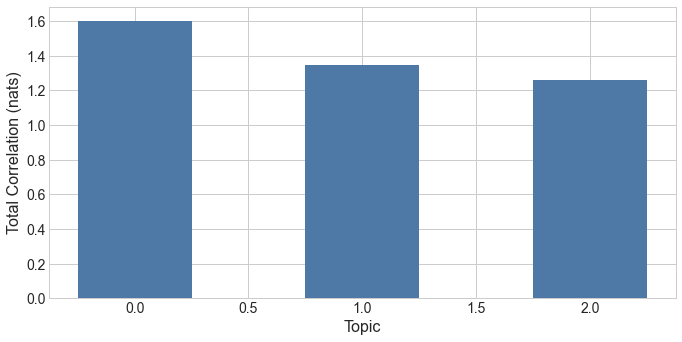

In [82]:
plt.figure(figsize=(10,5))
plt.bar(range(topic_model.tcs.shape[0]), topic_model.tcs, color='#4e79a7', width=0.5)
plt.xlabel('Topic', fontsize=16)
plt.ylabel('Total Correlation (nats)', fontsize=16);

"I'm not a huge fan of this (doesn't work that well, I think). I prefer taking the clean topics (e.g., 3 topics), anchoring them to hold them more or less fixed (next slide), then re-running CorEx with extra topics (e.g., 6), to see if any new clean topics come out. 
  * Repeat the above until topics are clean"

### Ways to Use CorEx
  * Use your domain knowledge (use anchors)
  * Use low anchor strength (2) in order to have as broad a match as possible

In [83]:
topic_model = ct.Corex(n_hidden=6, words=words,
                       max_iter=200, verbose=False, seed=1)

topic_model.fit(doc_word, words=words, docs=X_train, 
                anchors=[['sell'], 
                         ['ath'], 
                         ['prediction'], 
                         ['price'],
                         ['buy'], 
                         ['hodl']], anchor_strength=2)

# Print all topics from the CorEx topic model
topics = topic_model.get_topics()
for n,topic in enumerate(topics):
    topic_words,_ = zip(*topic)
    print('{}: '.format(n) + ','.join(topic_words))

0: sell,ratio,usdt,earn,pour,des,try,plus,eursum,eursell
1: que,para,los,por,ath,las,del,una,das,como
2: prediction,telegram,sec,channel,accurate,zonenext,status,predictions,trend,join
3: price,ltc,bch,xrp,eth,current,transferred,unknown,probability,counted
4: buy,people,like,time,dont,think,dip,panic,good,available
5: hodl,money,digital,world,amp,project,block,new,term,asset


### Ways to Use CorEx
  * __Highlight smaller topics that may be otherwise hidden by larger topics (use anchors)__
  * Use high anchor strength (5+) in order to force topics
    * Likely means that there will be fewer documents matched to the topic

In [84]:
topic_model = ct.Corex(n_hidden=6, words=words,
                       max_iter=200, verbose=False, seed=1)

topic_model.fit(doc_word, words=words, docs=X_train, 
#Why the double brackets??
                anchors=[['buy', 'sell'], 'prediction'], anchor_strength=10)

# Print all topics from the CorEx topic model
topics = topic_model.get_topics()
for n,topic in enumerate(topics):
    topic_words,_ = zip(*topic)
    print('{}: '.format(n) + ','.join(topic_words))

0: buy,sell,ratio,btcmask,supplier,masks,shop,antiviral,usdt,available
1: prediction,que,sec,telegram,accurate,zonenext,los,status,predictions,channel
2: people,like,markets,time,money,think,asset,amp,value,safe
3: ltc,eth,xrp,bch,wallet,transactions,transferred,unknown,probability,counted
4: market,thank,free,good,cap,project,crypto,pump,dont,great
5: proposal,business,size,pool,marketing,block,solution,complete,email,platform


### Ways to Use CorEx
  * __To see how the same word can be used in different topics (use anchors)__
  * Anchor the same word multiple times

In [85]:
topic_model = ct.Corex(n_hidden=8, words=words,
                       max_iter=200, verbose=False, seed=1)

topic_model.fit(doc_word, words=words, docs=X_train, 
                anchors=[['sell'], ['sell'], ['sell'], ['sell']], anchor_strength=5)

# Print all topics from the CorEx topic model
topics = topic_model.get_topics()
for n,topic in enumerate(topics):
    topic_words,_ = zip(*topic)
    print('{}: '.format(n) + ','.join(topic_words))

0: sell,que,los,por,las,para,del,una,como,cada
1: sell,ratio,usdt,bir,alerts,iin,daha,increase,dolar,alert
2: sell,email,ensure,efficient,businesses,les,customers,small,une,reach
3: sell,buy,earn,hunters,eursum,eurbuy,eurdifference,eursell,eurfirst,vays
4: like,people,market,safe,worth,information,money,markets,unknown,transferred
5: eur,btc,gbp,jpy,hardware,blood,opportunity,altn,work,stronger
6: ltc,eth,xrp,bch,free,available,hour,shop,boom,supplier
7: telegram,prediction,sec,accurate,status,channel,zonenext,predictions,block,join


### Resources and other ways to use CorEx

Take a look at the Github rep:
  * Main page: https://github.com/gregversteeg/corex_topic
  * Example notebook (MUST READ!): https://github.com/gregversteeg/corex_topic/blob/master/corextopic/example/corex_topic_example.ipynb

## Word2Vec and GloVe
Word2Vec is a very powerful and useful word embedding method. Gensim comes equipped with ways for us to train our own Word2Vec model, or load in a pre-trained word2vec model.

In [217]:
tokenized_docs = [gensim.utils.simple_preprocess(d) for d in df_tweets['tokens']] 

In [218]:
# size refers to the desired dimension of our word vectors
# window refers to the size of our context window
# why am I using skipgram?
# sg means that we are using the Skip-gram architecture

model1 = gensim.models.Word2Vec(tokenized_docs, size=5, window=2,min_count=1, sg=1)

In [219]:
model1.most_similar('btc' ,topn=10)

[('coinbase', 0.995563268661499),
 ('pair', 0.9921392202377319),
 ('arms', 0.9919389486312866),
 ('mai', 0.9906209707260132),
 ('nough', 0.990347146987915),
 ('upstairs', 0.9900001287460327),
 ('yayn', 0.9885592460632324),
 ('southeast', 0.9884265065193176),
 ('encuentro', 0.9881598949432373),
 ('personnel', 0.9880771636962891)]

In [220]:
model1.similarity('btc','hodl')

0.843982

In [221]:
# Positive Negative Similar Words
model1.most_similar(positive=['btc', 'buy'], negative=['sell'])

[('try', 0.9973786473274231),
 ('etmeliyim', 0.9952789545059204),
 ('dster', 0.9943414926528931),
 ('dal', 0.9924434423446655),
 ('mielt', 0.991824209690094),
 ('surveiller', 0.9911242723464966),
 ('arms', 0.9909156560897827),
 ('mai', 0.9901562929153442),
 ('phillip', 0.9887065887451172),
 ('analyze', 0.9885692596435547)]

In [222]:
model1.most_similar(positive=['btc', 'buy'], topn=5)

[('sell', 0.9990990161895752),
 ('try', 0.9980844259262085),
 ('dster', 0.9950941801071167),
 ('etmeliyim', 0.9946283102035522),
 ('dal', 0.993600606918335)]

Training our own model with word2vec is pretty cool, but it requires us to have a large corpus of data.

Fortunately, research groups at Stanford and Google have made their pre-trained word embeddings publicly available for us to use!

Google's word2vec: https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit

GloVe: https://nlp.stanford.edu/projects/glove/

Just note that these model's will require ~4 GB of RAM to fit in memory

In [1]:
# We are using vectors of length 200. Lesser vectors lessen processing time.
glove_file = './../Data/word_embeddings/glove.twitter.27B/glove.twitter.27B.200d.txt'
tmp_file = get_tmpfile("glove_word2vec.txt")

# call glove2word2vec script
# default way (through CLI): python -m gensim.scripts.glove2word2vec --input <glove_file> --output <w2v_file>
glove2word2vec(glove_file, tmp_file)

model = KeyedVectors.load_word2vec_format(tmp_file)

In [2]:
type(model.vocab)

dict

In [3]:
# Number of Vectors
len(model.vocab.keys())

1193514

In [4]:
# Size of the Vectors
model.vector_size

200

## Question 2
**Exploring Word2Vec Vectors**
* Print out a few word vectors from the Google set
* Print out the similarity between the following pairs (feel free to experiment with more if you like):
  * baseball, bat
  * baseball, ocean
  * bat, fly
* What sorts of patterns do you notice?  Where does it succeed?  Where does it fail?  How might one improve it?
* Print out the most similar words to the following words:
  * baseball
  * president
* Print out words similar to the positive words and dissimilar to the negative words for the following positive/negative groups:
* Print out the words that don't match the others in each of the following groups:

In [6]:
# Word Vectors
model.word_vec('bitcoin')

array([-0.074393 ,  0.10186  , -0.049351 , -0.53166  ,  0.25706  ,
       -0.5222   ,  0.17046  , -0.18893  ,  0.28897  , -0.12184  ,
        0.12619  ,  0.10341  , -1.0856   , -0.34959  ,  0.069433 ,
       -0.093725 , -0.33688  ,  0.46042  ,  0.65069  , -0.48376  ,
       -0.30007  ,  0.1678   ,  0.57996  , -0.10948  , -0.66832  ,
        0.7577   ,  0.41654  , -0.052058 , -0.59622  , -0.087796 ,
        0.4622   , -0.013795 , -0.44185  , -0.40651  ,  0.92432  ,
       -0.43312  , -0.012119 , -0.16346  ,  0.011646 , -0.33362  ,
        0.1437   ,  0.15696  ,  0.039093 ,  0.079893 ,  0.84927  ,
       -0.6614   , -0.76457  , -0.33192  ,  0.18674  ,  0.79411  ,
        0.57455  ,  0.1395   , -0.52864  ,  0.38603  ,  0.16032  ,
        0.52374  ,  0.49671  ,  0.37611  , -0.40939  ,  0.11506  ,
       -0.31058  , -0.2225   ,  0.34445  ,  0.01097  ,  0.64503  ,
       -0.063416 ,  0.4637   ,  0.29511  , -0.48942  ,  0.78048  ,
        0.52689  , -0.36406  ,  0.04378  ,  0.26221  ,  0.1767

In [7]:
# Pairwise Similarity
# Word2Vec captures some interesting similarities between words, such as the relationship between **bitcoin --> crypto**
model.similarity('bitcoin', 'crypto')

0.44594115

* Word Sense Disambiguation

In [8]:
# Most similar words
model.similar_by_word('bitcoin')

[('bitcoins', 0.6961264610290527),
 ('gox', 0.613304853439331),
 ('currency', 0.5955000519752502),
 ('exchange', 0.586264431476593),
 ('btc', 0.5816957354545593),
 ('dogecoin', 0.5782854557037354),
 ('trading', 0.5429692268371582),
 ('paypal', 0.5402452349662781),
 ('mining', 0.5222750902175903),
 ('commodity', 0.520323634147644)]

In [10]:
# Positive Negative Similar Words
model.most_similar(positive=['bit', 'gox'], negative=['scheme'])

[('abit', 0.4347763657569885),
 ('alittle', 0.41617801785469055),
 ('mt.', 0.4082877039909363),
 ('slightly', 0.401253879070282),
 ('little', 0.3616727590560913),
 ('pain', 0.34664636850357056),
 ('calmed', 0.3462069034576416),
 ('sad', 0.34080612659454346),
 ('angry', 0.340280145406723),
 ('much', 0.336826354265213)]

In [11]:
# Positive Negative Similar Words
model.most_similar(positive=['bit', 'gox'], negative=['scheme'],)

[('abit', 0.4347763657569885),
 ('alittle', 0.41617801785469055),
 ('mt.', 0.4082877039909363),
 ('slightly', 0.401253879070282),
 ('little', 0.3616727590560913),
 ('pain', 0.34664636850357056),
 ('calmed', 0.3462069034576416),
 ('sad', 0.34080612659454346),
 ('angry', 0.340280145406723),
 ('much', 0.336826354265213)]

It can also detect words that don't belong in a sequence:

In [14]:
# Words that don't match
model.doesnt_match(['breakfast', 'dinner'])

'breakfast'

## Question 3


word similarities

In [17]:
# Comparing via Cosine Similarity
model.n_similarity(['bitcoin', 'crypto'], ['blockchain', 'crypto'])

0.73180556

In [21]:
# Comparing via Word Mover's Distance

model.wmdistance(['bitcoin', 'crypto'], ['blockchain', 'crypto'])

3.9035424510822296

In [23]:
model.wmdistance("Bitcoin is the best of cryptocurrency".lower().split(), 
                        "Ethereum is the best of cryptocurrency".lower().split())

1.427231936853526

Other Resources:      
Doc2Vec extends the word2vec algorithm to larger blocks of texts (paragraphs, documents, articles):    
- https://radimrehurek.com/gensim/models/doc2vec.html
- http://learningaboutdata.blogspot.com/2014/06/plotting-word-embedding-using-tsne-with.html
- https://districtdatalabs.silvrback.com/modern-methods-for-sentiment-analysis
- https://radimrehurek.com/gensim/models/word2vec.html
- https://www.tensorflow.org/tutorials/word2vec